In [2]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/home/dmeyer/projects/bqtls/tdp43")
results_dir.mkdir(parents=True, exist_ok=True)

In [3]:
!ls /home/dmeyer/projects/bqtls/tdp43/allelic

tdp43_input_allelic.out		   tdp43_ip_allelic.out
tdp43_input_waspfiltered.bam	   tdp43_ip_waspfiltered.bam
tdp43_input_waspfiltered_sort.bam  tdp43_ip_waspfiltered_sort.bam


 Load input RNA allelic counts.

In [3]:
basedir = "/home/dmeyer/projects/bqtls/tdp43/allelic/"
input_files = [ basedir + "tdp43_input_allelic.out"]

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]
input_counts[0].head()

IP_files = [ basedir + "tdp43_ip_allelic.out" ]

IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]
IP_counts[0]

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,128747,rs565117739,A,C,11,1,12
1,chr1,137978,rs529853750,G,A,124,0,124
2,chr1,139029,rs531551691,C,T,45,0,45
3,chr1,139030,rs751110858,G,A,45,0,45
4,chr1,139060,rs568513188,G,A,37,0,37
...,...,...,...,...,...,...,...,...
1620755,chr22,50785210,rs138253809,C,T,22,0,22
1620756,chr22,50788205,.,A,T,11,0,11
1620757,chr22,50798982,.,G,A,26,0,26
1620758,chr22,50799058,.,G,C,31,0,31


Observed genotype data (after running StrandScript)

## Load imputed genotypes

In [18]:
!ls /home/dmeyer/projects/bqtls/

allhet_fixedH.1kg.vcf.gz	     old_secondround_bqtls
allhet_fixedH.1kg.vcf.gz.tbi	     sanger.feather
ipsc_imputation_het_hg38.vcf.gz      SecondRound_bQTLs
ipsc_imputation_het_hg38.vcf.gz.tbi  tdp43


In [1]:
#geno = io_utils.loadGenotypes(
#    '/home/dmeyer/projects/bqtls/ipsc_imputation_het_hg38.vcf.gz',
#    maxlines = None, 
#    posterior = False,
#    print_every = 1e5,
#    add_chr_prefix="").rename(columns = {"SNP" : "variantID"})
#geno.reset_index().to_feather('/home/dmeyer/projects/bqtls/ipsc_imputation_het_hg38.feather')

In [4]:
#sanger_feather = Path("/home/dmeyer/projects/bqtls/ipsc_imputation_het_hg38.feather")
sanger_feather = Path("/home/dmeyer/projects/bqtls/sanger.feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [5]:
#sanger=sanger[list(sanger.columns[[1,0]])+list(sanger.columns[2:])]
sanger = sanger.rename(columns = {"variantID": "SNP"})

In [6]:
#[f"{sanger.contig[i]}:{sanger.position[i]}:{sanger.refAllele[i]}:{sanger.altAllele[i]}" for i in range(sanger.shape[0])]

In [7]:
sanger = sanger[sanger.SNP != "."]
sanger = sanger[~sanger.SNP.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway

cols = list(sanger.columns)
cols[0], cols[1] = cols[1], cols[0]
sanger = sanger.loc[:,cols]

## Look at phase within genes

In [8]:
import gc
gc.collect()

7

In [12]:
#sample_ind = [ g for g in cols if "CW" in g ][0]
sample_ind = [ g for g in cols if "CW70142" in g ][0]

In [13]:
sample_ind

'CW70142-1-1194512527_CW70142-1-1194512527'

In [14]:
cols

['contig',
 'position',
 'SNP',
 'refAllele',
 'altAllele',
 'CW30274-1-1194512543_CW30274-1-1194512543',
 'CW30454-1-1194512472_CW30454-1-1194512472',
 'CW30421-1-1194512512_CW30421-1-1194512512',
 'CW70372-1-1194512488_CW70372-1-1194512488',
 'CW40201-1-1194512480_CW40201-1-1194512480',
 'CW30525-1-1194512464_CW30525-1-1194512464',
 'CW30190-1-1194512504_CW30190-1-1194512504',
 'CW30108-1-1194512496_CW30108-1-1194512496',
 'CW30154-1-1194512551_CW30154-1-1194512551',
 'CW70179-1-1194512535_CW70179-1-1194512535',
 'CW70142-1-1194512527_CW70142-1-1194512527']

In [19]:
import vcf
import gzip
vcf_reader = vcf.Reader(filename = '/home/dmeyer/projects/bqtls/sanger.vcf.gz')
#vcf_reader = vcf.Reader(filename = '/home/dmeyer/projects/bqtls/ipsc_imputation_het_hg38.vcf.gz')

#gen = [next(vcf_reader) for _ in range(10000)]
gen = vcf_reader

v = [ (record.CHROM, 
 record.POS, 
 record.ID, 
 record.REF, 
 record.ALT[0].sequence, 
 record.genotype(sample_ind).data.GT, 
 record.genotype(sample_ind).data.ADS[0],
 record.genotype(sample_ind).data.ADS[1]) 
      for record in gen if (record.genotype(sample_ind).data.GT != "0|0") ]

chroms, pos, ids, ref, alt, gt, ads1, ads2 = zip(*v)
phased = pd.DataFrame({
    "contig" : chroms,
    "position" : pos,
    "SNP" : ids, 
    "refAllele" : ref, 
    "altAllele" : alt, 
    "GT" : gt, 
    "dosage1" : ads1, # dosage for haplotype 1
    "dosage2" : ads2 # dosage for haplotype 2
})

phased.to_csv(
    '/home/dmeyer/projects/bqtls/CW70142.phased.csv', 
    index = False, 
    sep = "\t")

In [20]:
phased

,contig,position,SNP,refAllele,altAllele,GT,dosage1,dosage2
0,10,69083,None,C,T,1|1,0.75,0.75
1,10,95353,None,G,A,1|1,0.75,0.75
2,10,101023,None,A,G,1|1,0.85,0.85
3,10,109082,None,T,C,1|1,0.85,0.85
4,10,117636,None,A,G,1|1,0.85,0.85
...,...,...,...,...,...,...,...,...
3038864,9,141077352,rs1902482,T,C,1|1,0.95,1.00
3038865,9,141078304,rs4102299,C,T,1|1,0.95,1.00
3038866,9,141087366,rs1820789,A,G,1|1,0.95,1.00
3038867,9,141099663,rs12340415,C,G,1|0,0.85,0.00


In [21]:
phased.SNP = phased.SNP.astype('str')
phased.contig = "chr" + phased.contig
phased_clean = phased[phased.SNP != "None"]

In [22]:
dat = input_counts[0]
dat_IP = IP_counts[0]

dat = dat[dat.variantID != "."]
dat = dat[~dat.variantID.duplicated()]
dat_IP = dat_IP[dat_IP.variantID != "."]
dat_IP = dat_IP[~dat_IP.variantID.duplicated()]

imp_merged = phased_clean.rename(
    columns = {"SNP" : "variantID"}
).merge(
    dat, 
    on = ["contig", "variantID", "refAllele", "altAllele"],
    suffixes = ["_hg19",""]) # sanger is hg19
imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount


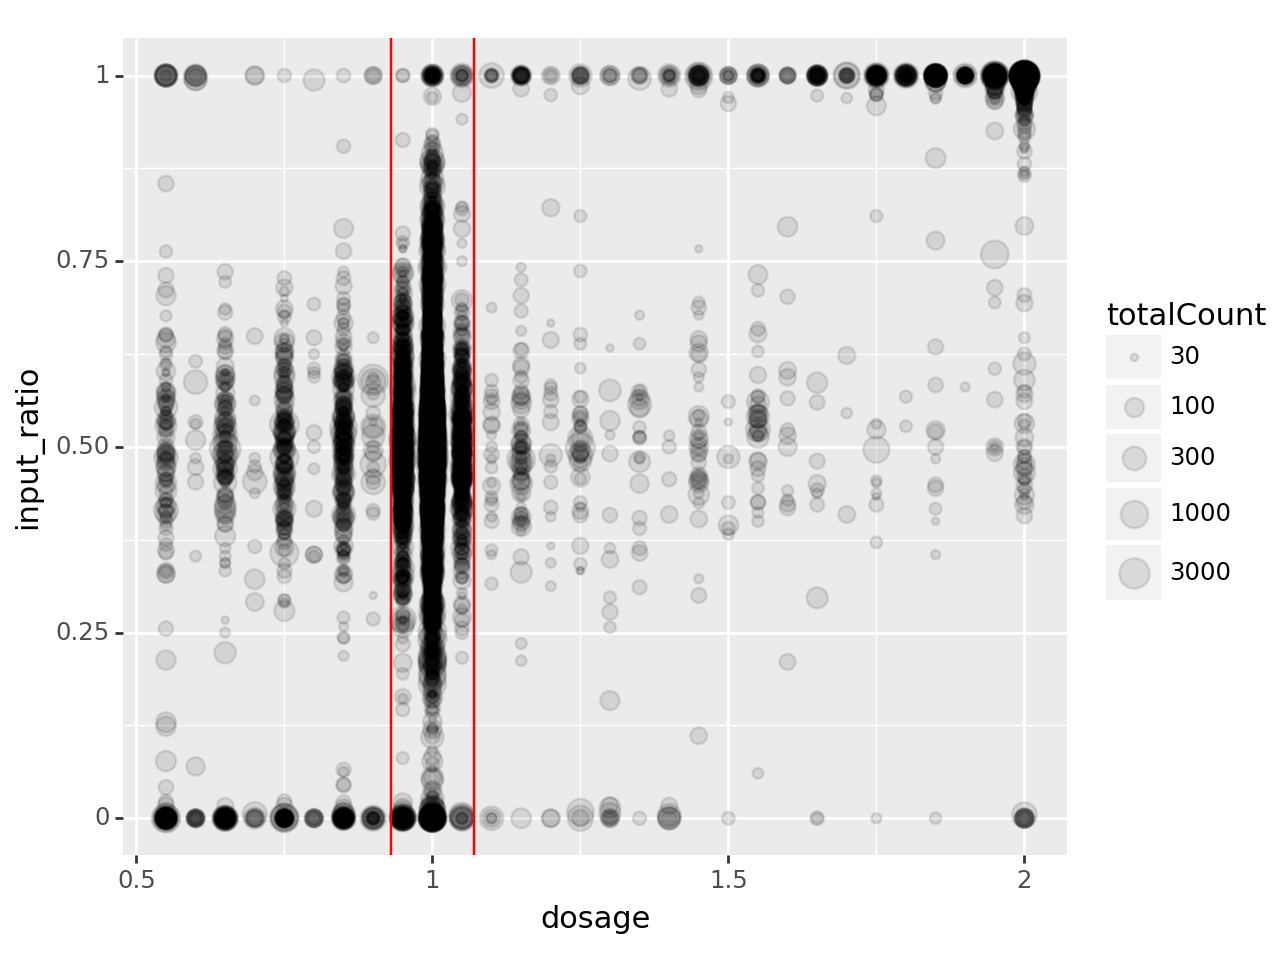

<Figure Size: (640 x 480)>

In [23]:
imp_merged["dosage"] = imp_merged.dosage1 + imp_merged.dosage2

import plotnine as p9
( p9.ggplot(imp_merged[imp_merged.totalCount >= 30], p9.aes("dosage", "input_ratio", size = "totalCount")) + 
 p9.geom_point(alpha = 0.1) + 
 p9.scale_size(trans = "log10") + 
 p9.geom_vline(xintercept = [.93,1.07], color = "red") )

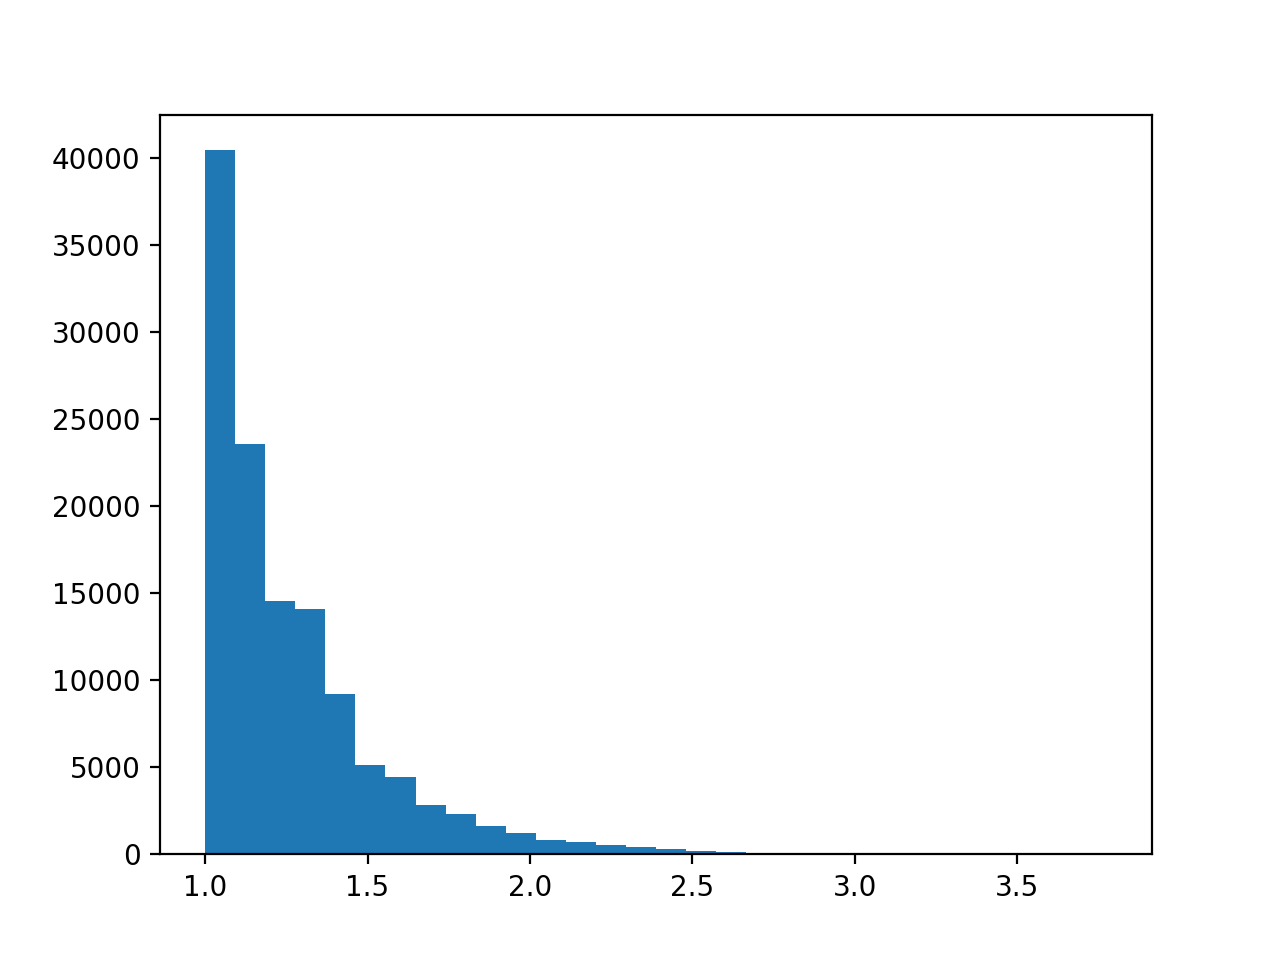

In [24]:
%matplotlib inline
_ = plt.hist(np.log10(imp_merged.totalCount), 30) # when/where did this get filtered?! only includes totalCount >= 10

In [25]:
het = imp_merged[np.logical_and(imp_merged.dosage > 0.93, imp_merged.dosage < 1.07)].copy()
het["phased_ratio"] = np.where(het.GT == "0|1", het.input_ratio, 1. - het.input_ratio)
het

,contig,position_hg19,variantID,refAllele,altAllele,GT,dosage1,dosage2,position,refCount,altCount,totalCount,input_ratio,dosage,phased_ratio
2,chr10,406942,rs56400883,C,G,0|1,0.00,0.95,361002,3,10,13,0.769231,0.95,0.769231
7,chr10,459940,rs4881274,G,A,0|1,0.00,1.00,414000,20,18,38,0.473684,1.00,0.473684
30,chr10,865825,rs12218845,C,T,1|0,1.00,0.00,819885,14,7,21,0.333333,1.00,0.666667
33,chr10,888398,rs11253461,A,T,0|1,0.00,1.00,842458,6,7,13,0.538462,1.00,0.538462
34,chr10,903950,rs11253471,A,G,1|0,1.00,0.00,858010,10,4,14,0.285714,1.00,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122809,chr9,140969853,rs7032692,C,A,0|1,0.05,1.00,138075401,4,10,14,0.714286,1.05,0.714286
122810,chr9,140969861,rs10780200,C,T,0|1,0.05,1.00,138075409,5,10,15,0.666667,1.05,0.666667
122813,chr9,140999200,rs62579480,G,A,1|0,1.00,0.00,138104748,8,4,12,0.333333,1.00,0.666667
122814,chr9,141001866,rs10867107,T,C,0|1,0.00,1.00,138107414,5,5,10,0.500000,1.00,0.500000


In [26]:
from sklearn.neighbors import NearestNeighbors

dists = []
rats = []

for chrom in range(1,23):
    print(chrom, end = "\r")
    chrdat = het[het.contig == ("chr%i" % chrom)]
    chrdat = chrdat[chrdat.totalCount >= 30]
    X = chrdat.position.to_numpy().reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=5).fit(X)
    distances, indices = nbrs.radius_neighbors(X, radius = 2000)
    phased_ratio = chrdat.phased_ratio.to_numpy()
    ratios = np.concatenate([ (phased_ratio[i] - phased_ratio[j]) for i,j in enumerate(indices) ])
    dist = np.concatenate(distances)
    to_keep = dist > 0
    dists.append( dist[to_keep] )
    rats.append( ratios[to_keep] )


In [27]:
p = het.phased_ratio[het.totalCount >= 30]
s = p.std()
np.sqrt(2.) * s

0.18664863808142446

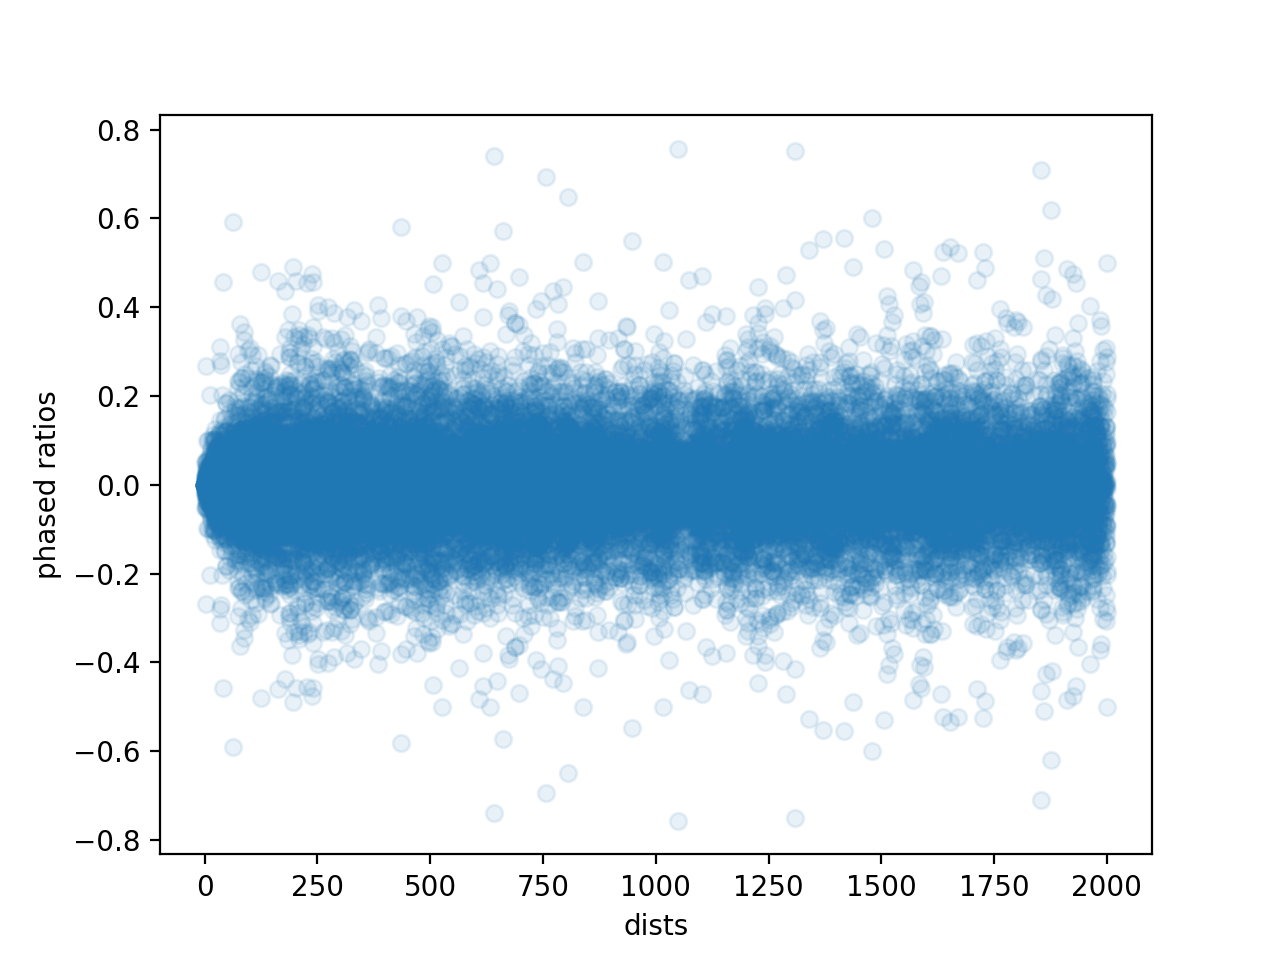

In [28]:
dist = np.concatenate(dists)
ratios = np.concatenate(rats)
plt.scatter(dist, ratios, alpha = 0.1)
plt.xlabel("dists")
plt.ylabel("phased ratios")
plt.show()

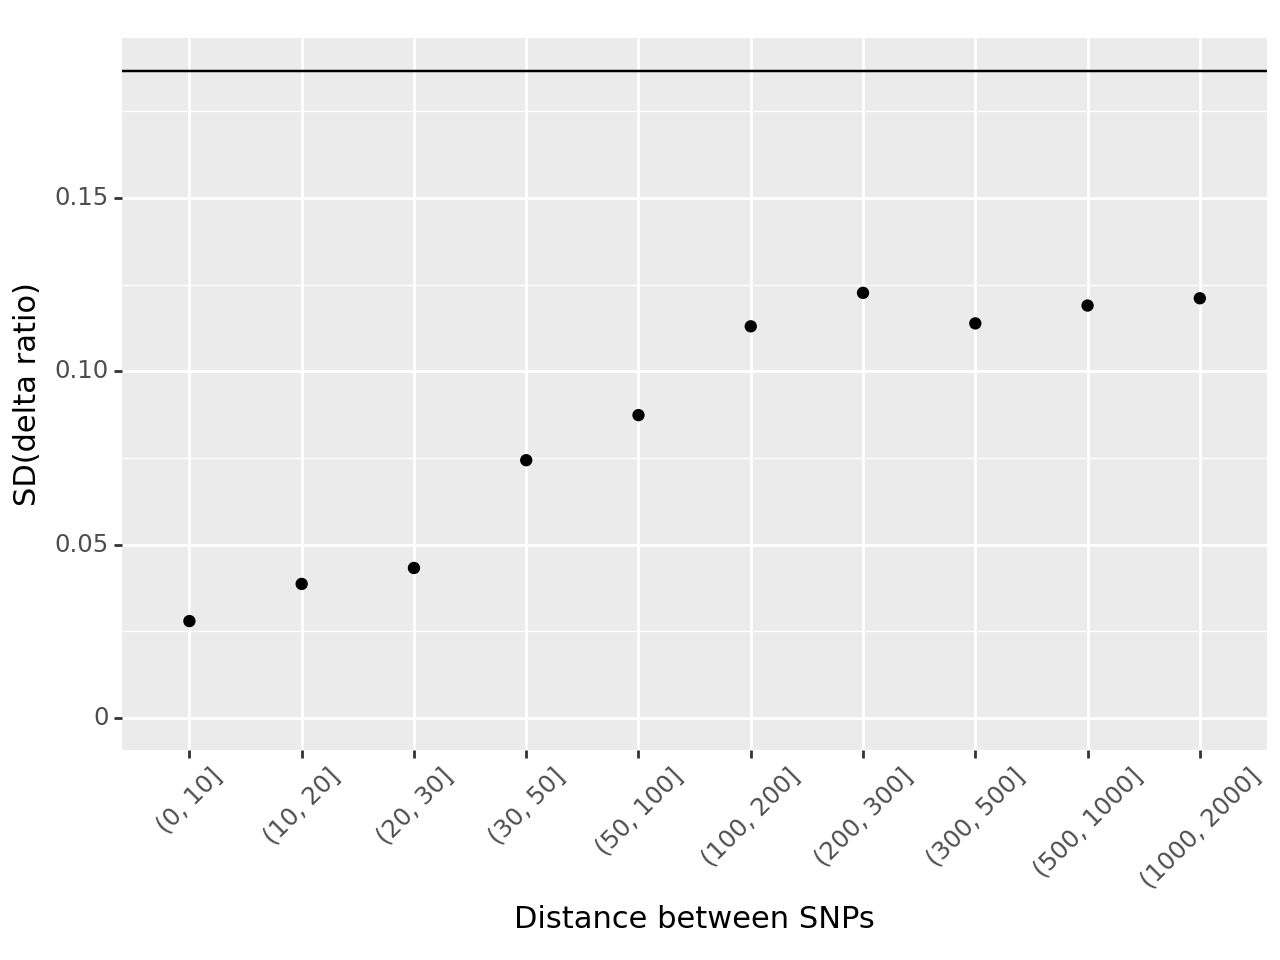

<Figure Size: (640 x 480)>

In [29]:
delta = pd.DataFrame({ "dist" : dist, "delta_ratio" : ratios})
delta["dist_discrete"] = pd.cut(
    delta.dist,
    bins=[0, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 2000])

summed = delta.groupby('dist_discrete', as_index=False).agg({'delta_ratio' : 'std'})

( p9.ggplot(summed, p9.aes("dist_discrete", 'delta_ratio')) + 
 p9.geom_point() + 
 p9.theme(axis_text_x = p9.element_text(angle = 45)) + 
 p9.ylab("SD(delta ratio)") + 
 p9.xlab("Distance between SNPs") + 
 p9.geom_hline(yintercept = np.sqrt(2.) * s) +
 p9.expand_limits(y = [0])
)

In [30]:
from pooledQTL import interval_utils

exons = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/gencode.v38.exons.txt.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
exons = exons[(exons.end - exons.start) >= 9] # remove super short exons

In [78]:
len(chroms)

3038869

In [84]:
sanger.shape

(34582504, 16)

In [85]:
#exons_tree = interval_utils.to_interval_trees(exons, chroms)
#overlap["exonic"] = interval_utils.get_overlap(exons_tree, overlap)

In [31]:
genes = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/genes.tsv.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
genes = genes[genes.end - genes.start >= 100]

In [ ]:
genes_tree = interval_utils.to_interval_trees(genes, chroms)

overlap["genic"] = interval_utils.get_overlap(genes_tree, overlap)

# Load IP count data and join with input and genotype

<Axes: >

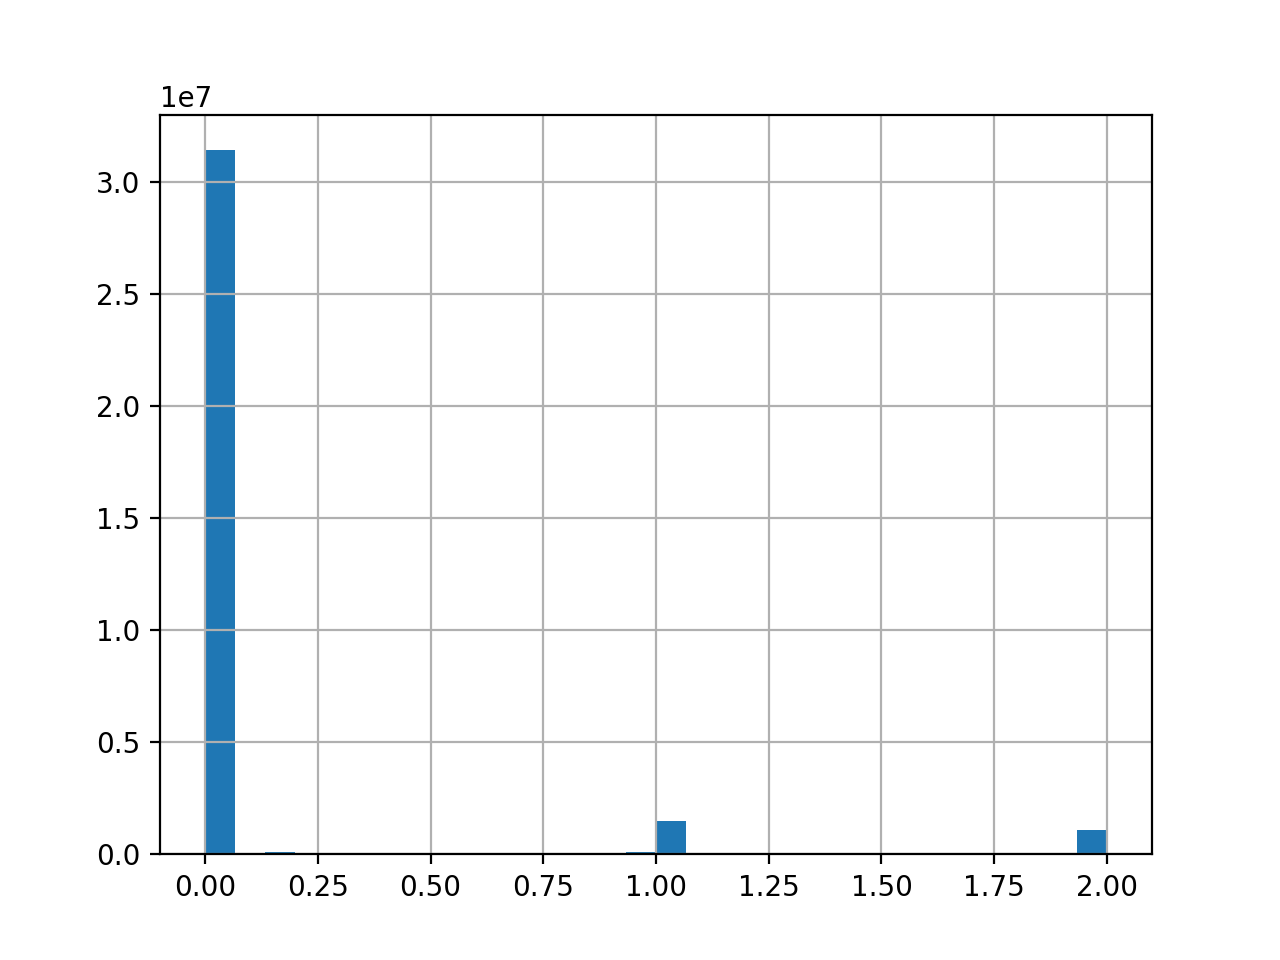

In [32]:
%matplotlib inline
sanger[sample_ind].hist(bins=30)

In [33]:
[ g.totalCount.sum()/1e6 for g in IP_counts ]

[52.895062]

In [34]:
[ g.totalCount.sum()/1e6 for g in input_counts ]

[59.148037]

Joining genotype and input allelic counts. 
Have to match on rsID because sanger.vcf is hg19 and allelic counts are on hg38


In [36]:
dat = input_counts[0]
dat_IP = IP_counts[0]

dat = dat[dat.variantID != "."]
dat = dat[~dat.variantID.duplicated()]
dat_IP = dat_IP[dat_IP.variantID != "."]
dat_IP = dat_IP[~dat_IP.variantID.duplicated()]

imp_merged = sanger.rename(
    columns = {"SNP" : "variantID"}
).merge(
    dat, 
    on = ["contig", "variantID", "refAllele", "altAllele"],
    suffixes = ["_hg19",""]) # sanger is hg19
# there are only 0.08% flipped alleles so not worth doing.
# np.isnan(imp_merged.iloc[:,5:16]).any() all False
imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount

In [37]:
sanger

,contig,position,SNP,refAllele,altAllele,CW30274-1-1194512543_CW30274-1-1194512543,CW30454-1-1194512472_CW30454-1-1194512472,CW30421-1-1194512512_CW30421-1-1194512512,CW70372-1-1194512488_CW70372-1-1194512488,CW40201-1-1194512480_CW40201-1-1194512480,CW30525-1-1194512464_CW30525-1-1194512464,CW30190-1-1194512504_CW30190-1-1194512504,CW30108-1-1194512496_CW30108-1-1194512496,CW30154-1-1194512551_CW30154-1-1194512551,CW70179-1-1194512535_CW70179-1-1194512535,CW70142-1-1194512527_CW70142-1-1194512527
0,chr10,60494,rs568182971,A,G,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,chr10,60523,rs112920234,T,G,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,chr10,60803,rs536478188,T,G,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,chr10,61020,rs115033199,G,C,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,chr10,61314,rs569207726,T,C,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39131573,chr9,141111414,rs558431167,G,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39131574,chr9,141112371,rs563889179,G,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39131575,chr9,141127361,rs528107815,G,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39131576,chr9,141127558,rs553270612,G,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


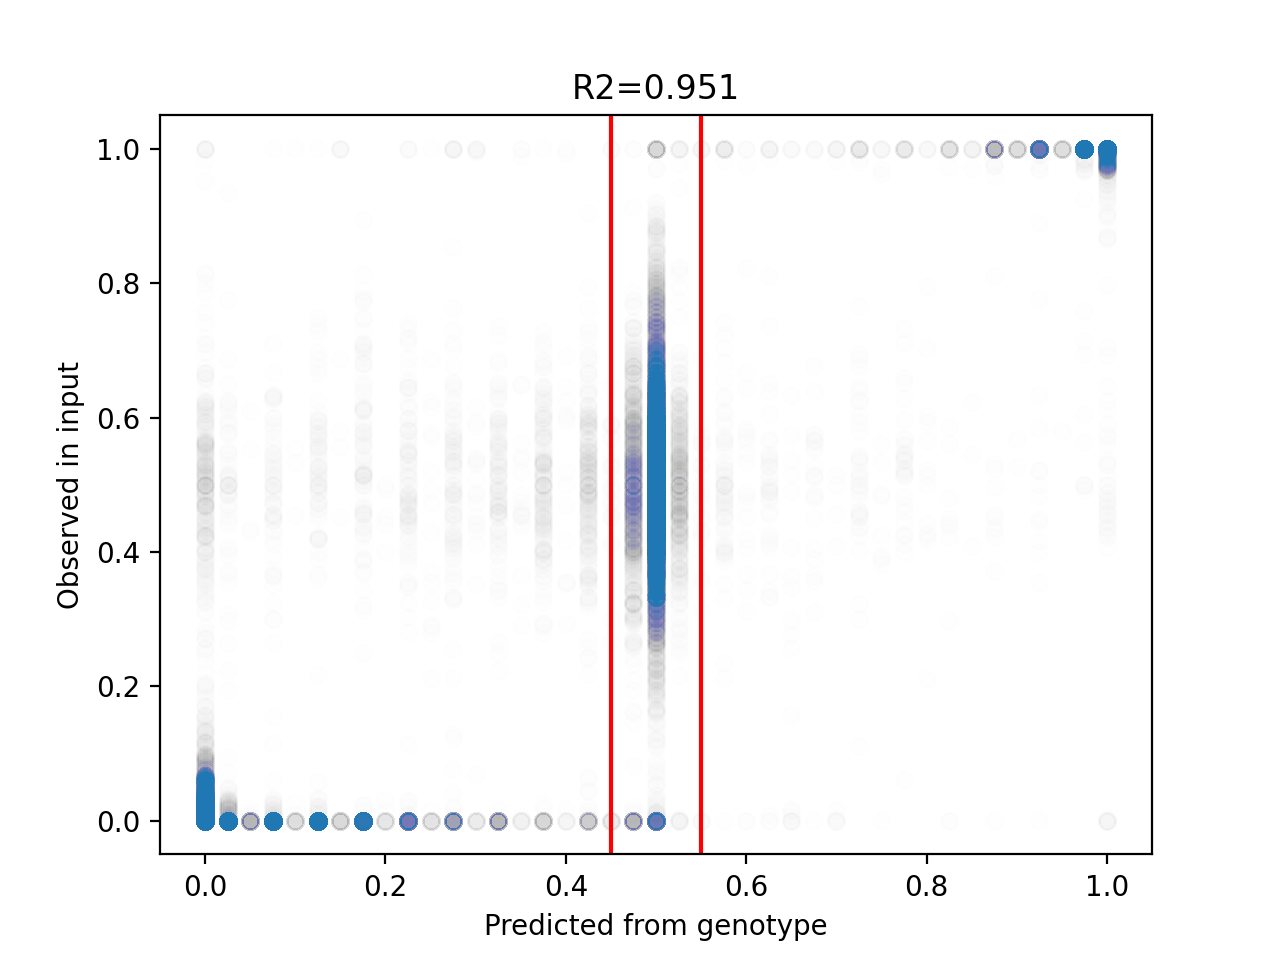

In [38]:
imp_merged["pred_ratio"] = 0.5 * imp_merged.loc[:,sample_ind].to_numpy()

imp_merged_30 = imp_merged[imp_merged.totalCount >= 30]
corr,_ = scipy.stats.pearsonr(imp_merged_30.pred_ratio, imp_merged_30.input_ratio)
R2 = corr*corr
plt.scatter(imp_merged_30.pred_ratio, imp_merged_30.input_ratio, alpha = 0.005) 
plt.title("R2=%.3f" % R2)
plt.xlabel("Predicted from genotype")
plt.ylabel("Observed in input")
plt.axvline(x = 0.45, color = 'r')
plt.axvline(x = 0.55, color = 'r')
plt.show()

Joining genotype+input with IP allelic counts

In [39]:
merged = imp_merged.drop(
    labels=sanger.columns[range(5,16)], axis=1 # # .rename(columns={"position_y":"position"} # ,"contig_x":"contig" ?
).merge(
    dat_IP, 
    on = ("contig", "position", "variantID", "refAllele", "altAllele"), 
    suffixes = ("_input", "_IP"))
#merged = merged.drop(labels=["contig_y", "position_x" ], axis=1)

merged["IP_ratio"] = merged.altCount_IP / merged.totalCount_IP

input_total_min = 10
allele_count_min = 4 
ip_total_min = 30

# filter for reasonable counts
dat_sub = merged[merged.totalCount_input >= input_total_min]
dat_sub = dat_sub[dat_sub.refCount_input >= allele_count_min]
dat_sub = dat_sub[dat_sub.altCount_input >= allele_count_min]
dat_sub = dat_sub[dat_sub.totalCount_IP >= ip_total_min]
dat_sub = dat_sub[dat_sub.pred_ratio >= 0.45]
dat_sub = dat_sub[dat_sub.pred_ratio <= 0.55]

In [40]:
dat_subsub = dat_sub[dat_sub.pred_ratio == 0.5]

<Axes: >

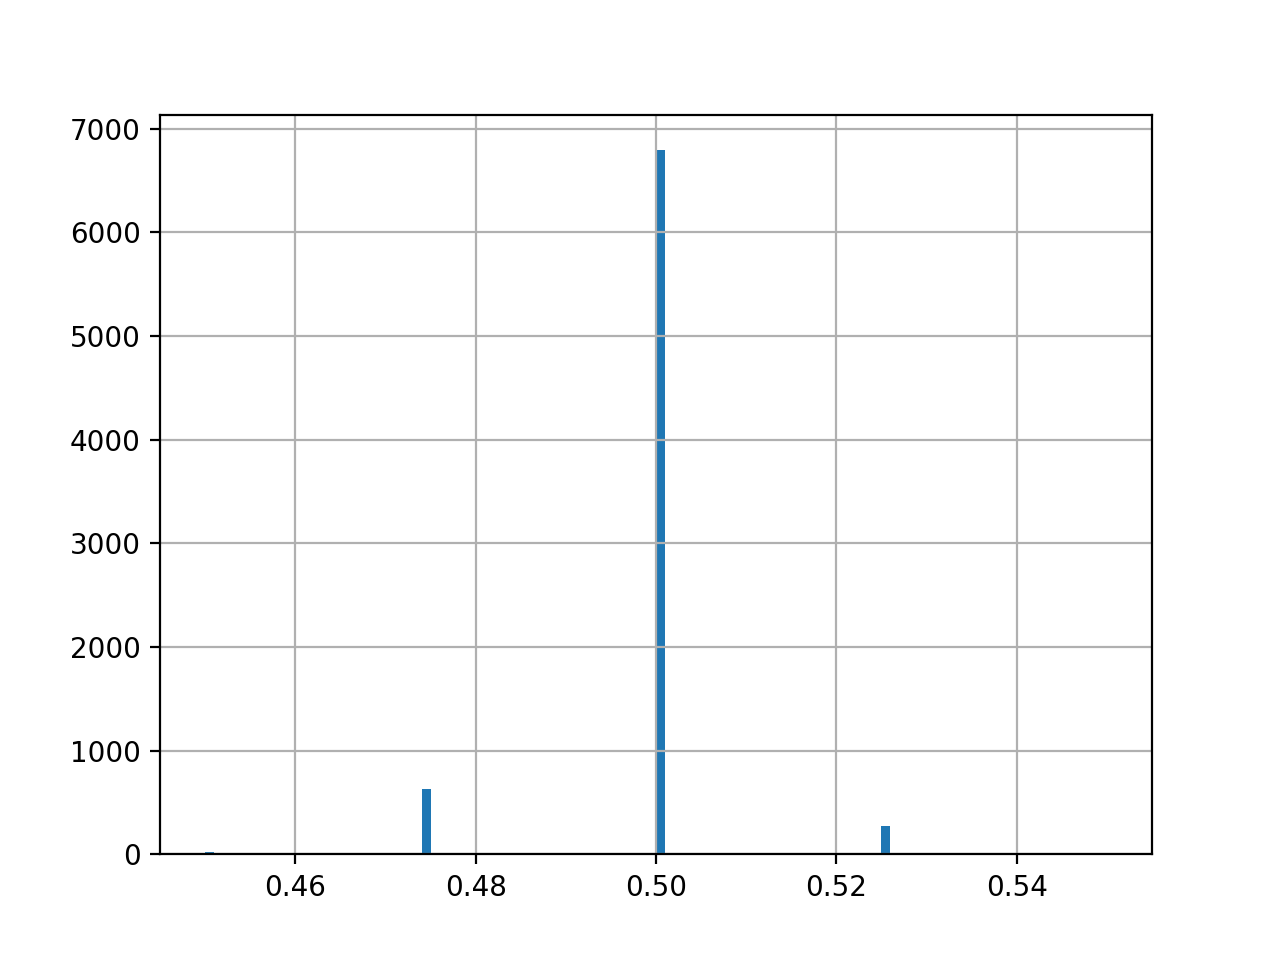

In [41]:
dat_sub.pred_ratio.hist(bins=100)

# Run beta models

In [42]:
results_dir

PosixPath('/home/dmeyer/projects/bqtls/tdp43')

In [46]:
results_file = results_dir / ("beta_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")

In [43]:
results = beta_model.fit_and_save(dat_subsub, 
                                 results_dir / ("beta" 
                                                + ("_struct" if use_structured_guide else "") 
                                                + ".tsv.gz"),
                                 use_structured_guide = True,
                                 iterations = 1000,
                                 device = device)
results

KeyboardInterrupt: 

In [ ]:
ggplot_data.columns

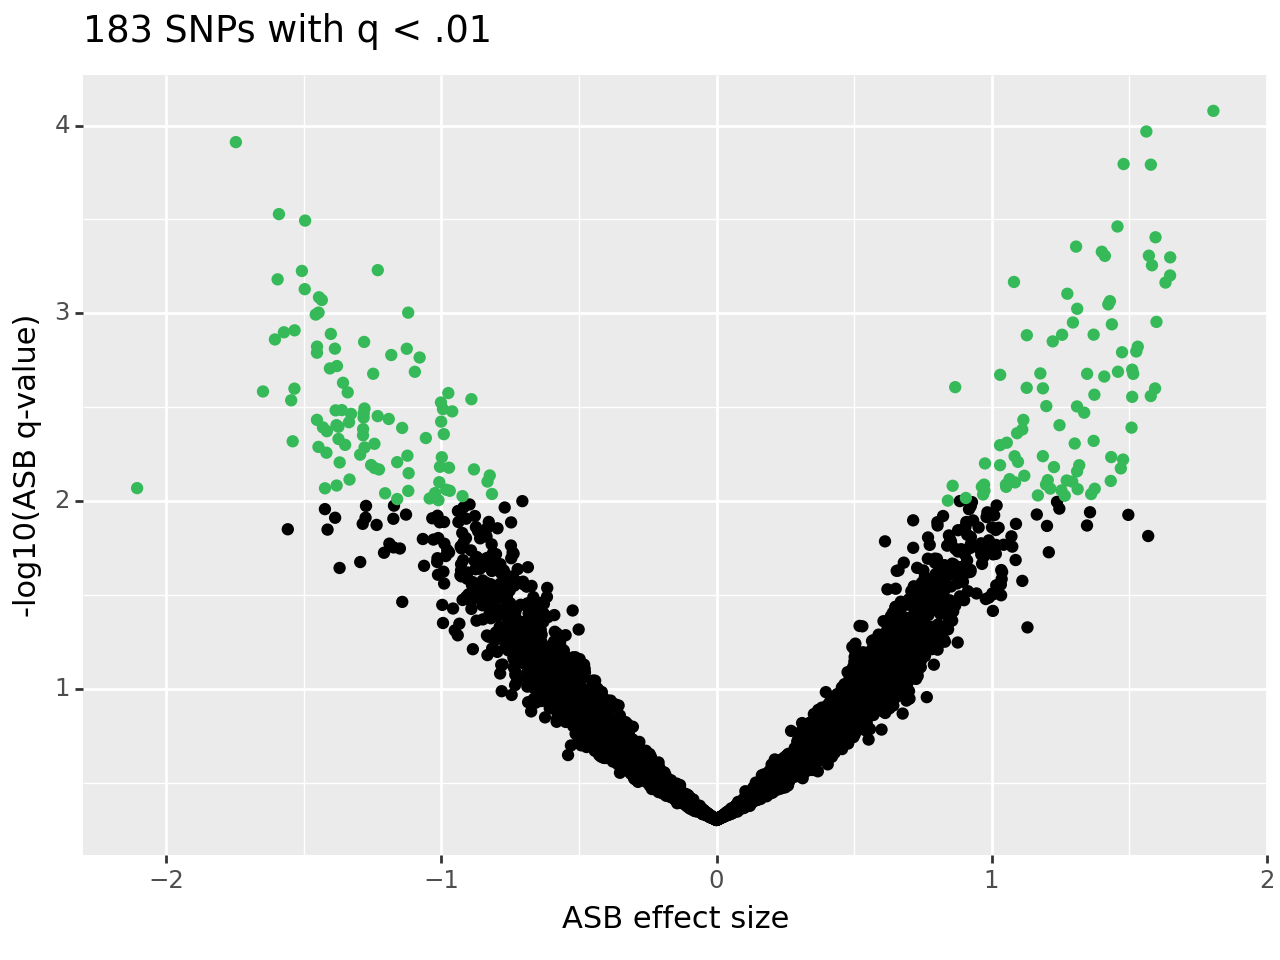

<Figure Size: (640 x 480)>

In [173]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "-np.log10(asb_q)")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59')+
    p9.labs(x = "ASB effect size", y = "-log10(ASB q-value)", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

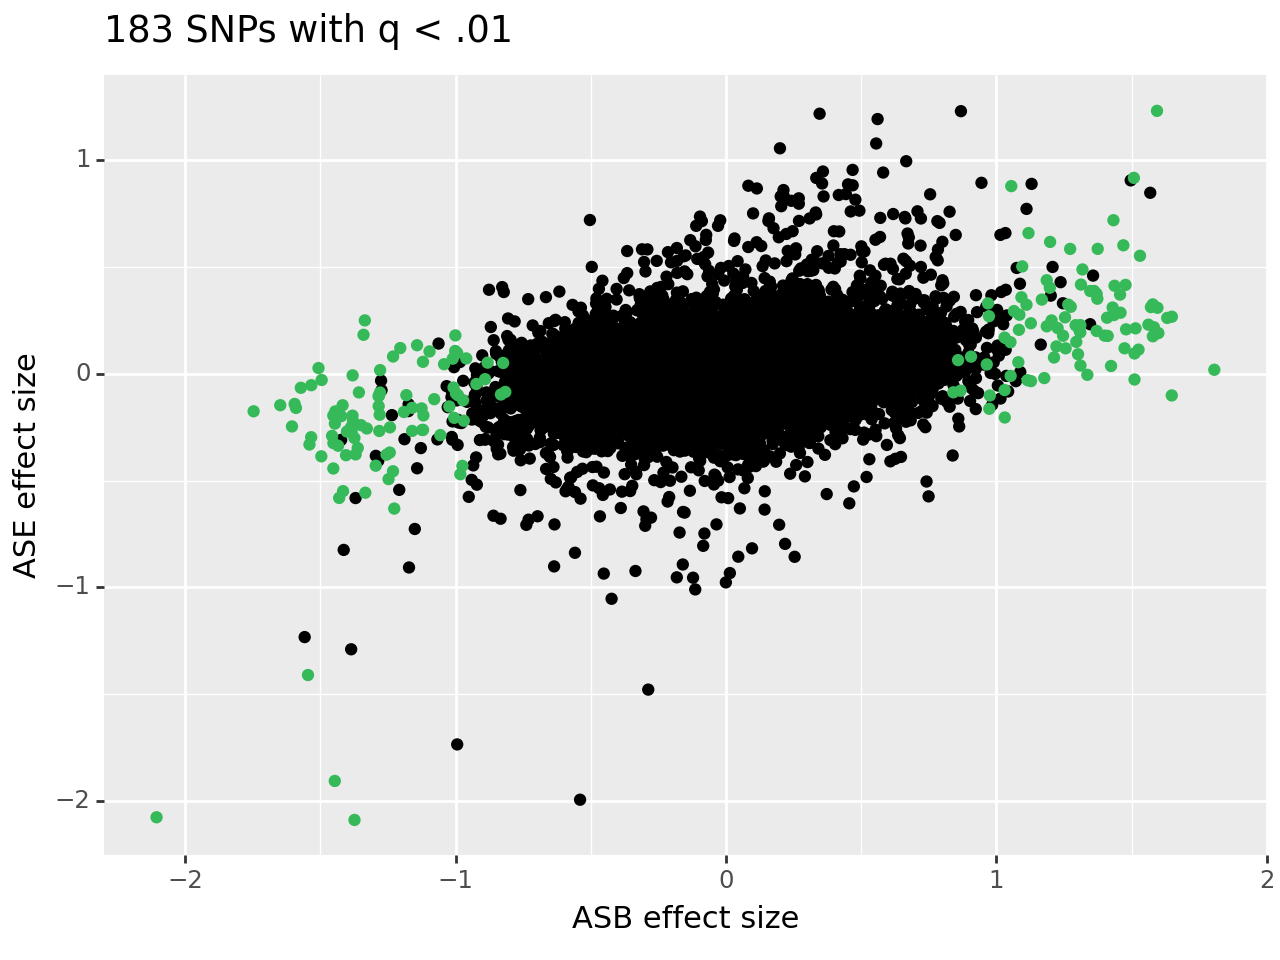

<Figure Size: (640 x 480)>

In [175]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

For intersecting Peaks and SNPs you can use `bedtools -U` or use the interval tree that David sent

Want to filter out based on peaks so you don't get the bias

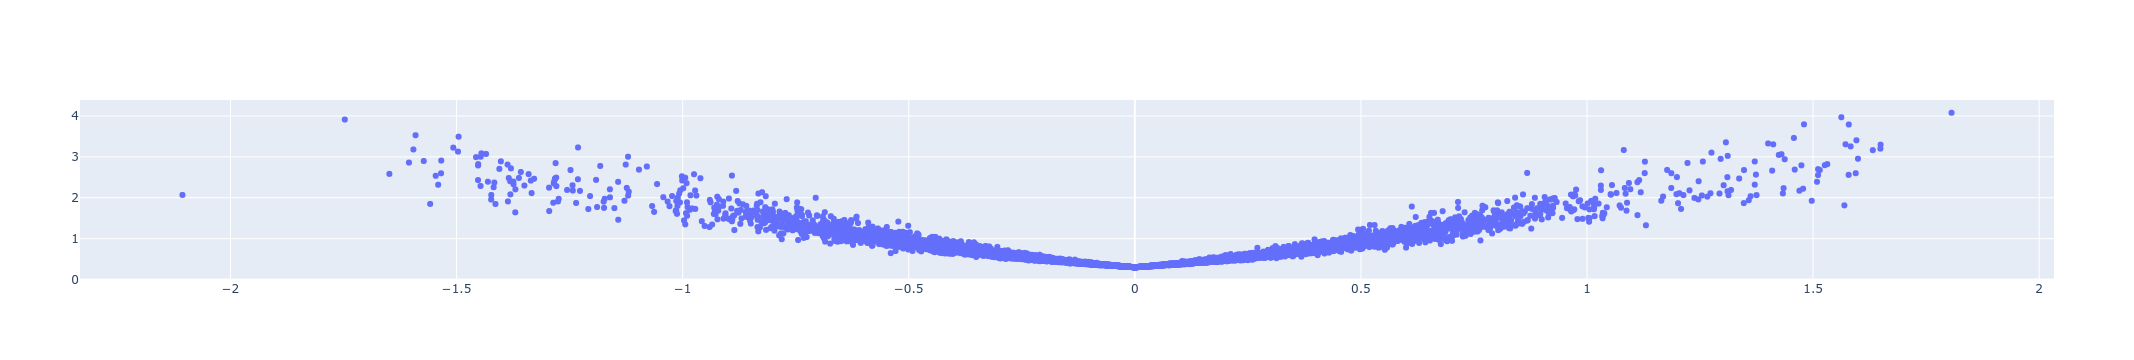

In [132]:
import plotnine as p9
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

ggplot_data = results

plotly_trace = go.Scatter(x=ggplot_data['asb_loc'], y=-np.log10(ggplot_data['asb_q']), text = ggplot_data["variantID"], mode='markers', )
fig = make_subplots()
fig.add_trace(plotly_trace)
fig.show()

In [168]:
results[(results.asb_q < .01) & (np.abs(results.asb_loc) > 1) & 
        (results.refCount_input > 4) &
        (results.altCount_input > 4) &
        (results.refCount_IP    > 4) &
        (results.altCount_IP    > 4)
       ][["variantID", "refAllele", "altAllele", "refCount_input", "altCount_input", "refCount_IP", "altCount_IP", "ase_loc", "ase_q", "asb_loc", "asb_q"]]

,variantID,refAllele,altAllele,refCount_input,altCount_input,refCount_IP,altCount_IP,ase_loc,ase_q,asb_loc,asb_q
966,rs4594115,A,T,15,6,8,66,-0.076130,0.377125,1.030768,0.006443
1317,rs4774360,C,T,6,7,92,9,-0.206024,0.240971,-1.005312,0.006573
2418,rs60795647,C,G,6,8,6,51,0.206043,0.225607,1.083594,0.005776
2844,rs16856484,G,A,41,64,5,52,0.323517,0.034418,1.111505,0.004159
3024,rs1040554,C,T,46,23,5,38,-0.204541,0.165072,1.031175,0.002128
4694,rs4013,C,T,36,46,6,48,0.148214,0.265656,1.052217,0.008178
4703,rs223410,T,C,45,28,5,49,-0.029771,0.438758,1.115435,0.003698
5050,rs258017,C,T,24,35,159,20,0.081145,0.350657,-1.231360,0.000589
5519,rs4816,G,A,35,55,32,6,0.179938,0.174485,-1.001002,0.003778
5743,rs34661737,T,A,10,9,56,6,-0.162013,0.272025,-1.125952,0.001545


rs10005067 is a risk allele for "Total body bone mineral density (age 30-45)" falls in a large intergenic region
rs28028 is in an intronic region of SEMA6A gene; no clear GWAS signal or clinical significance
rs6684 in exonic region of NDUFAF4 gene; no clear GWAS signal or clinical significance
rs17126159 ROR1 : Intron Variant with no reported clinical significance

In [112]:
fdr_threshold

0.05

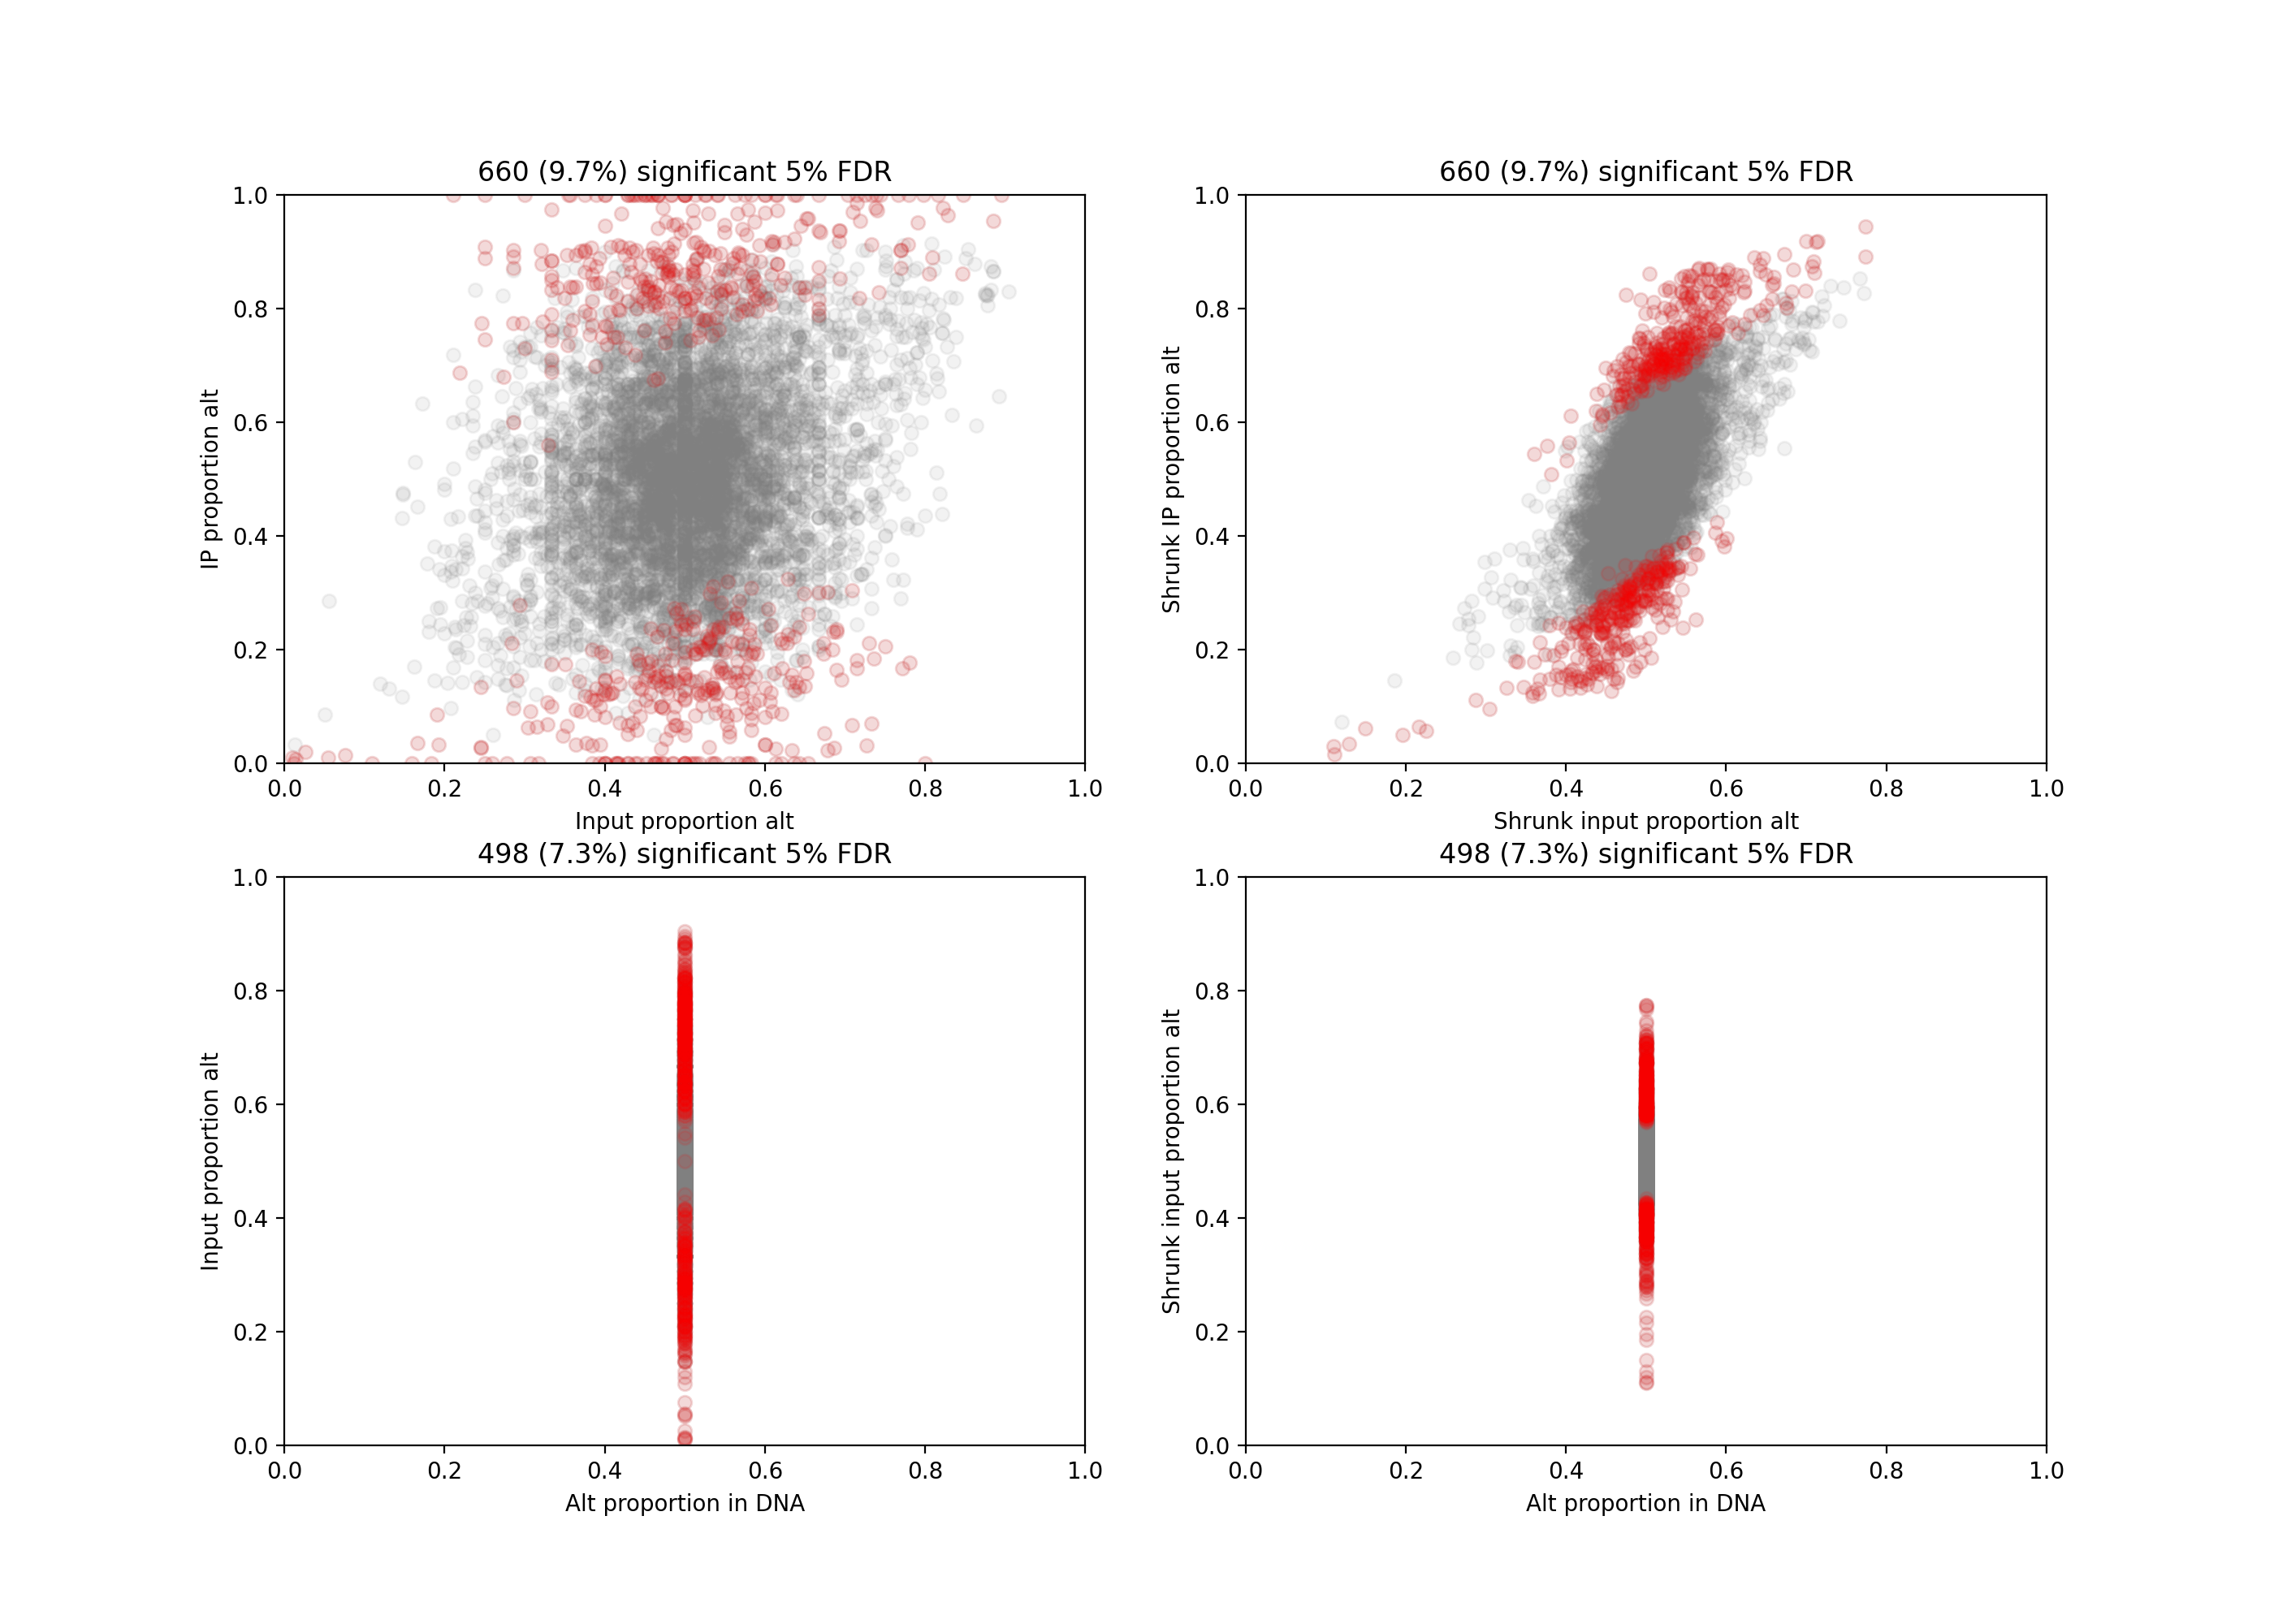

()

In [114]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold=0.05, sig_alpha=0.1)

For the beta model we model the two ratios (input and IP) separately but allow posterior dependence through the structured guide. For the Gaussian model we model the ASE effect (difference between DNA and RNA logit ratio) and ASB effect (difference between RNA and IP logit ratio). 

# Gaussian model without replicates

Could also run this with the mean field guide. 

In [107]:
%matplotlib inline
results = gaussian_model.fit_and_save(dat_subsub, 
                                         results_dir / ("normal" 
                                                        + ("_struct" if use_structured_guide else "") 
                                                        + ".tsv.gz"),
                                         use_structured_guide = True,
                                         iterations = 1000,
                                         device = "cuda:0")

Learned hyperparameters: {'ase_scale': 0.21795596182346344, 'input_count_conc': 245.8440399169922, 'asb_scale': 0.5056506395339966, 'IP_count_conc': 20.21240234375, 'ase_t_df': 3.47109055519104, 'asb_t_df': 5.234928131103516}


AttributeError: 'tuple' object has no attribute 'input_ratio'

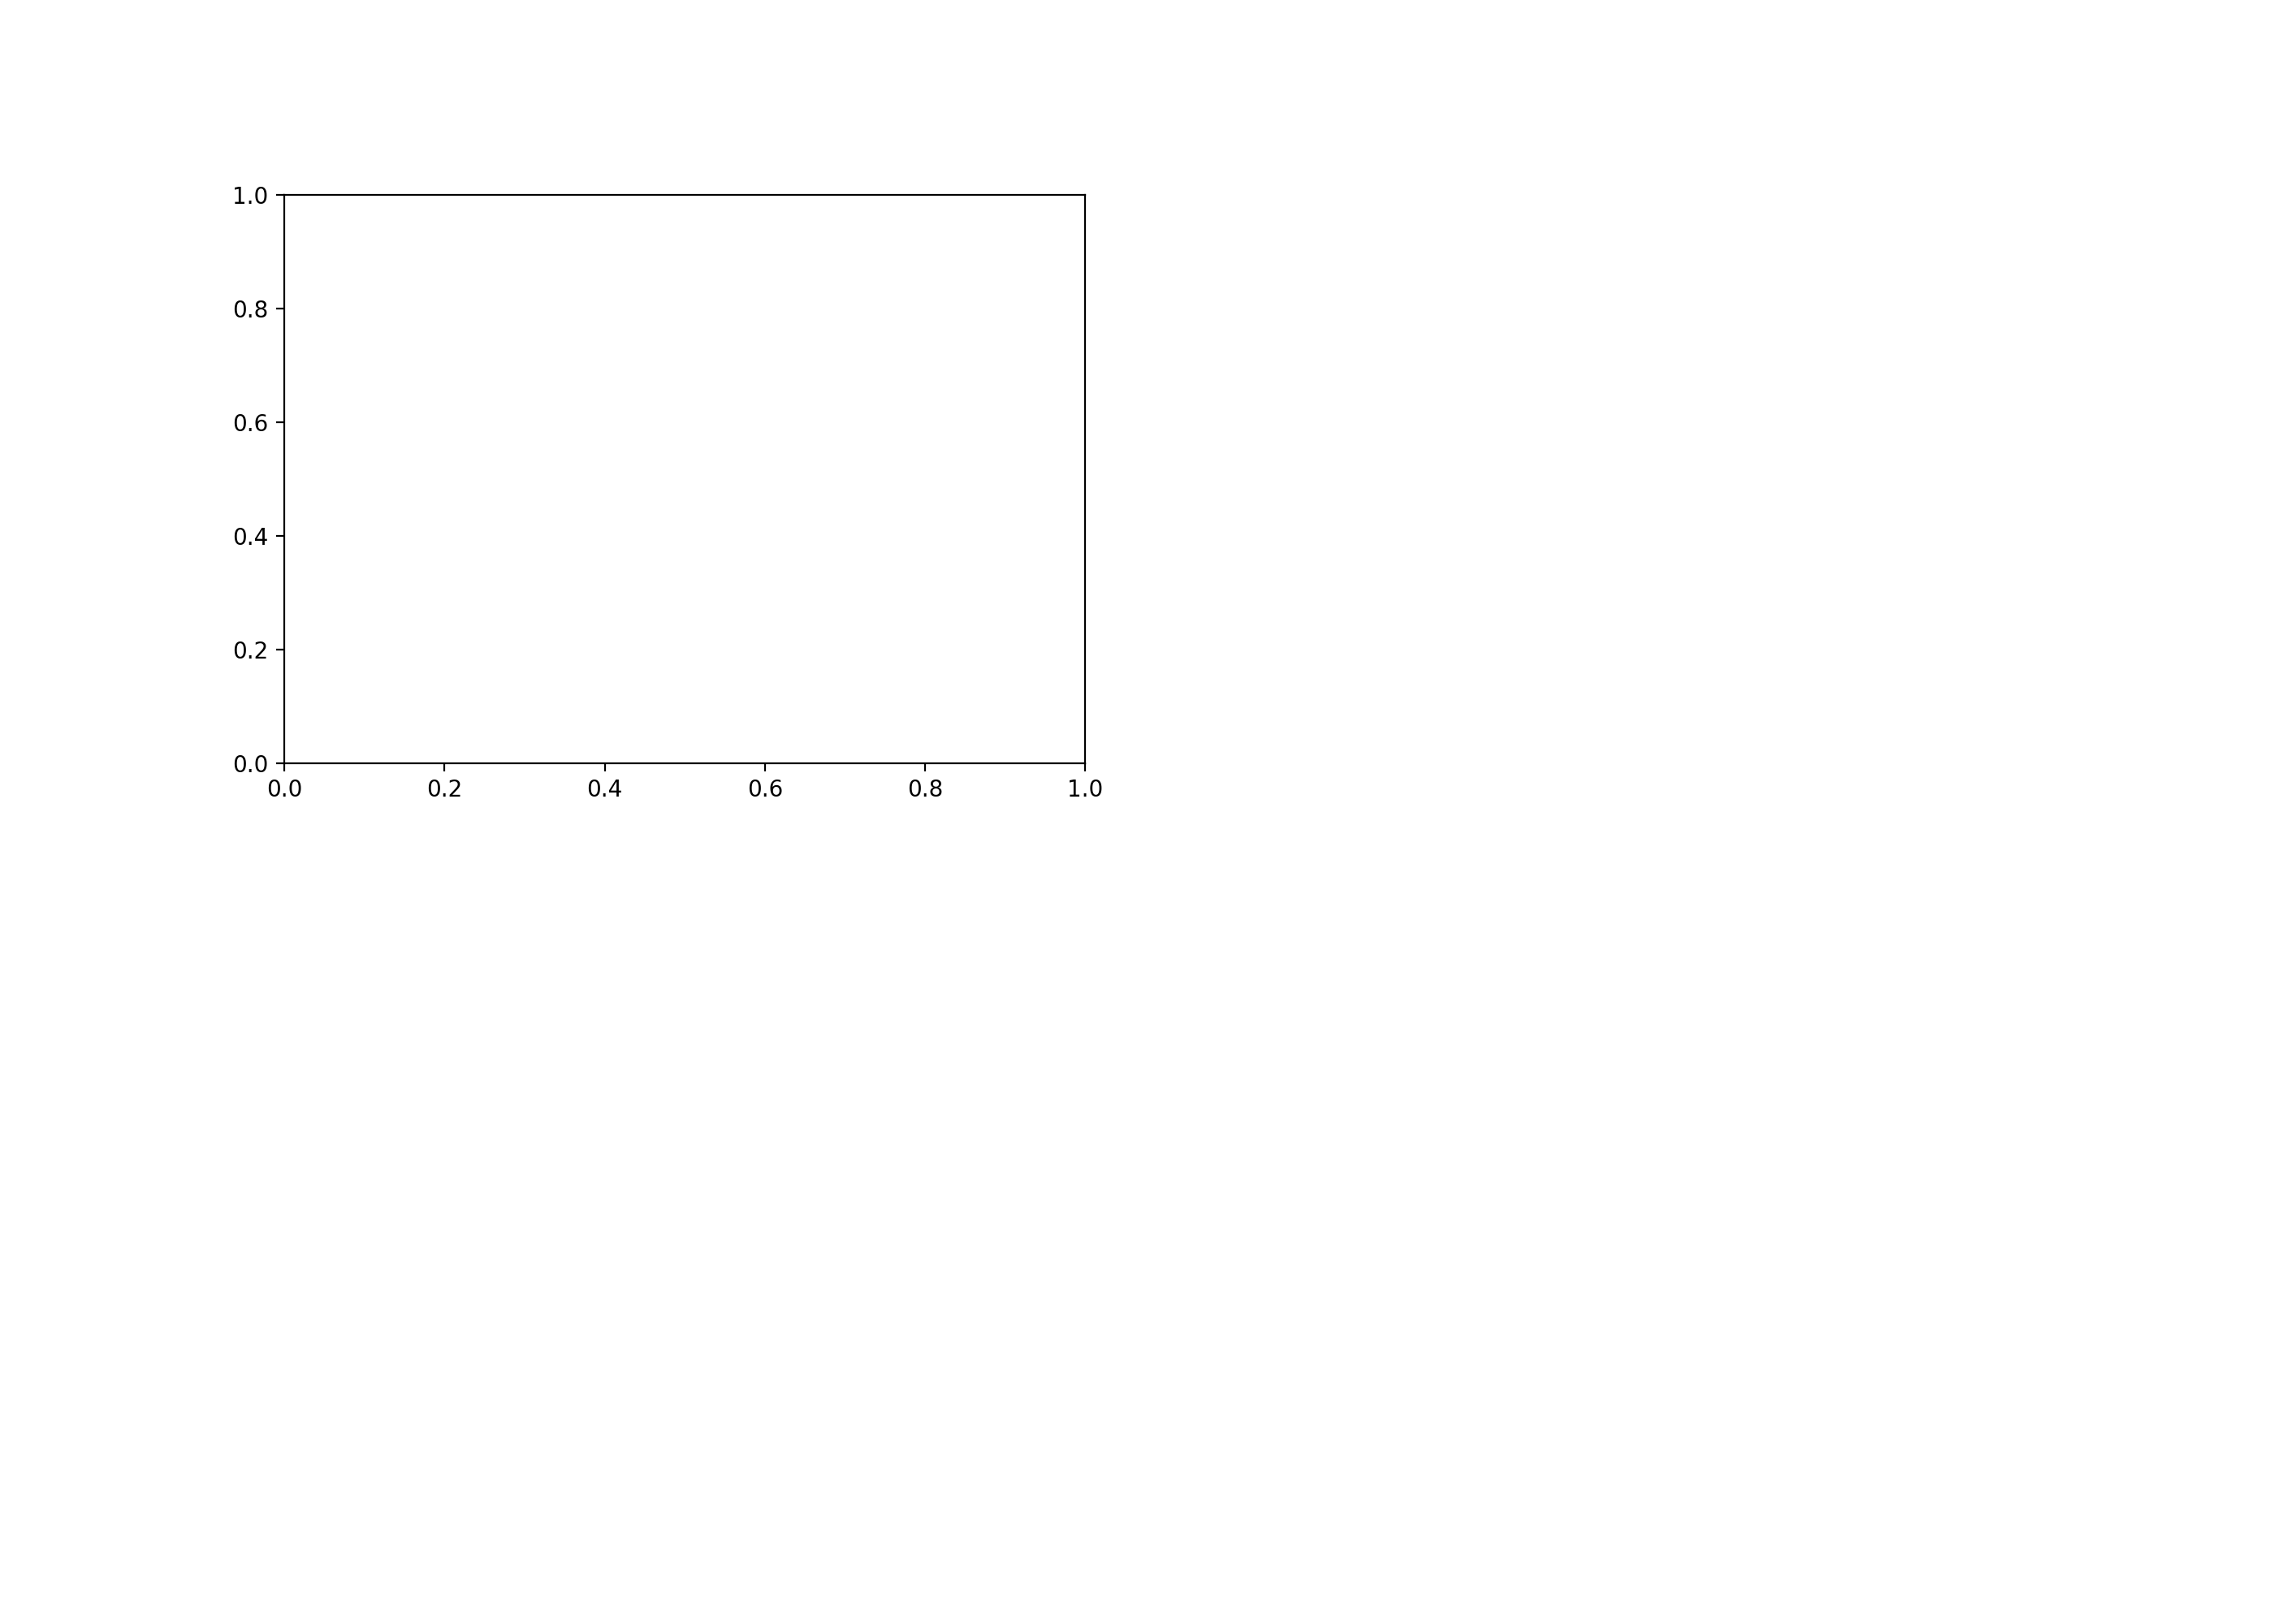

In [108]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold, sig_alpha=0.4)

## Overlap peak information:

.narrowPeak format: 
```
chrom - Name of the chromosome (or contig, scaffold, etc.).
chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.
chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature. For example, the first 100 bases of a chromosome are defined as chromStart=0, chromEnd=100, and span the bases numbered 0-99.
name - Name given to a region (preferably unique). Use "." if no name is assigned.
score - Indicates how dark the peak will be displayed in the browser (0-1000). If all scores were "'0"' when the data were submitted to the DCC, the DCC assigned scores 1-1000 based on signal value. Ideally the average signalValue per base spread is between 100-1000.
strand - +/- to denote strand or orientation (whenever applicable). Use "." if no orientation is assigned.
signalValue - Measurement of overall (usually, average) enrichment for the region.
pValue - Measurement of statistical significance (-log10). Use -1 if no pValue is assigned.
qValue - Measurement of statistical significance using false discovery rate (-log10). Use -1 if no qValue is assigned.
peak - Point-source called for this peak; 0-based offset from chromStart. Use -1 if no point-source called.
```

In [48]:
peaks_file = Path("/home/dmeyer/projects/bqtls/tdp43-all_peaks.narrowPeak")

In [49]:
peaks = pd.read_csv(peaks_file, 
                    header = None,
                    names= ["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"],
                    sep = "\t",  
                    index_col = False)
peaks.head()

,chrom,start,end,name,score,strand,signalValue,pValue,qValue,peak
0,chr1,158915,159155,tdp43-neg_peak_39,176,-,11.64159,21.13101,17.61224,116
1,chr1,517500,517778,tdp43-neg_peak_40,127,-,9.65268,16.14668,12.77275,134
2,chr1,633959,634171,tdp43-neg_peak_41,193,-,5.70766,22.88932,19.32727,83
3,chr1,788853,789421,tdp43-neg_peak_42,104,-,8.64755,13.77396,10.48722,196
4,chr1,789666,790983,tdp43-neg_peak_43,235,-,14.09245,27.25767,23.59893,1185


In [50]:
peak_tree = interval_utils.to_interval_trees(peaks, peaks.chrom.unique())

In [ ]:
genes_tree = interval_utils.to_interval_trees(genes, chroms)
peaks = 

to_interval_trees(peakdf, chroms):
genes_tree = interval_utils.to_interval_trees(genes, chroms)

In [73]:
from pooledQTL import interval_utils

exons = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/gencode.v38.exons.txt.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
exons = exons[(exons.end - exons.start) >= 9] # remove super short exons

In [75]:
exons_tree = interval_utils.to_interval_trees(exons, exons.chrom.unique())

In [65]:
results["in_peak"] = interval_utils.get_overlap(peak_tree, results.rename(columns={"contig": "chrom"}))

In [76]:
results["in_exon"] = interval_utils.get_overlap(exons_tree, results.rename(columns={"contig": "chrom"}))

In [77]:
results.rename(columns={"contig": "chrom"})

,chrom,position_hg19,variantID,refAllele,altAllele,position,refCount_input,altCount_input,totalCount_input,pred_ratio,...,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q,in_peak,in_exon
0,chr10,1040138,rs7070724,G,A,994198,8,8,16,0.5,...,0.009045,0.009045,0.242887,0.485147,-0.181023,-0.190068,0.457175,0.338798,0,0
1,chr10,1046712,rs2306409,G,A,1000772,51,74,125,0.5,...,0.136659,0.136659,0.200529,0.247780,-0.435006,-0.571664,0.424223,0.088901,0,1
2,chr10,1065191,rs17221491,A,G,1019251,4,10,14,0.5,...,0.145541,0.145541,0.320083,0.324664,0.228376,0.082835,0.447758,0.426614,0,1
3,chr10,1675548,rs12267329,A,G,1633353,5,6,11,0.5,...,0.171201,0.171201,0.249057,0.245916,0.689264,0.518062,0.441253,0.120183,1,0
4,chr10,1682481,rs10903520,G,A,1640286,6,10,16,0.5,...,-0.036610,-0.036610,0.232647,0.437479,-0.279682,-0.243072,0.439876,0.290272,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,chr9,139318071,rs7628,A,G,136423619,55,50,105,0.5,...,-0.180091,-0.180091,0.226761,0.213543,-0.209754,-0.029663,0.444518,0.473398,0,1
6785,chr9,139335599,rs1127152,A,G,136441147,37,19,56,0.5,...,-0.331026,-0.331026,0.213242,0.060290,-0.584175,-0.253149,0.471046,0.295489,0,1
6786,chr9,139371786,rs6560632,A,C,136477334,43,24,67,0.5,...,-0.328250,-0.328250,0.206881,0.056295,-0.575466,-0.247216,0.392782,0.264545,0,1
6787,chr9,139618283,rs6873,A,G,136723831,34,31,65,0.5,...,-0.084877,-0.084877,0.211950,0.344411,-0.901133,-0.816257,0.346087,0.009174,0,1


In [81]:
f'{sum((results["asb_q"] < 0.05) & (results["in_peak"] == 1))/sum(results["asb_q"] < 0.05)*100:.3}% of hits in peaks'

'12.6% of hits in peaks'

In [72]:
results[(results["asb_q"] < 0.05) & (results["in_peak"] == 1)]

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input,altCount_input,totalCount_input,pred_ratio,...,totalCount_IP,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q,in_peak
16,chr10,3162904,rs114964193,T,G,3120712,10,12,22,0.5,...,46,0.130916,0.130916,0.242681,0.294785,0.837034,0.706118,0.407591,0.041600,1
237,chr10,125157127,rs117421392,C,T,123397611,4,10,14,0.5,...,33,0.070365,0.070365,0.258286,0.392646,-0.694818,-0.765182,0.396229,0.026732,1
272,chr10,134998066,rs4838671,C,T,133184562,7,5,12,0.5,...,208,-0.002768,-0.002768,0.239321,0.495386,0.827187,0.829956,0.413721,0.022424,1
360,chr11,47437403,rs2293578,C,T,47415852,19,18,37,0.5,...,202,-0.189779,-0.189779,0.200045,0.171391,-0.690932,-0.501154,0.301710,0.048352,1
485,chr11,117133672,rs552176,A,G,117262956,4,6,10,0.5,...,37,-0.216147,-0.216147,0.249425,0.193086,-1.206328,-0.990181,0.516098,0.027518,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6411,chr8,101726965,rs1786319,T,C,100714737,8,6,14,0.5,...,36,-0.407350,-0.407350,0.244236,0.047672,-1.693513,-1.286163,0.579520,0.013231,1
6612,chr9,90128429,rs1316489,A,G,87513514,19,16,35,0.5,...,50,-0.295695,-0.295695,0.242712,0.111556,-1.309898,-1.014204,0.449180,0.011976,1
6670,chr9,101874314,rs10819638,C,T,99112032,14,7,21,0.5,...,138,-0.176318,-0.176318,0.214342,0.205367,0.475239,0.651558,0.344581,0.029321,1
6676,chr9,102896238,rs2761056,A,G,100133956,11,7,18,0.5,...,64,0.076987,0.076987,0.234403,0.371290,0.944620,0.867633,0.482507,0.036074,1


In [ ]:
results[(results["asb_q"] < 0.05) & (results["in_peak"] == 1)]

In [70]:
results["in_peak"].unique()

array([0, 1])